# __Using ModelingToolkit NonlinearSystem models with EAGO__
[Joseph Choi](https://www.linkedin.com/in/joseph-2-choi/)  
Process Systems and Operations Research Laboratory, Dept. of Chemical and Biomolecular Engineering, University of Connecticut

[Prof. Matthew Stuber](https://chemical-biomolecular.engr.uconn.edu/people/faculty/stuber-matthew/)  
Process Systems and Operations Research Laboratory, Dept. of Chemical and Biomolecular Engineering, University of Connecticut


This is a tutorial for exporting ModelingToolkit `NonlinearSystem` models as standard Julia functions, which can then be used as EAGO-compatible equality constraints in JuMP models.

#### __Required Libraries__
- Julia environment v1.10.4
- `ModelingToolkit.jl` v9.24.0
- `JuMP.jl` v1.22.2
- `EAGO.jl` v0.8.1
- `GLPK.jl` v1.2.1

***
### __1. &nbsp; Defining Nonlinear System__ 
The system of interest is derived from an example originally presented by [Kokossis and Floudas (1991)](https://doi.org/10.1016/0009-2509(91)85063-4) that involves a continuous stirred-tank reactor (CSTR) and separator train (with recycle) for the chlorination of benzene with the following reactions taking place:
\begin{array}{rcl}
\text{C}_6\text{H}_6 + \text{Cl}_2 &\rightarrow& \text{C}_6\text{H}_5\text{Cl}+ \text{HCl}\\
\text{C}_6\text{H}_5\text{Cl} + \text{Cl}_2 &\rightarrow& \text{C}_6\text{H}_4\text{Cl}_2+ \text{HCl}\\
\end{array}
where the rate constants $k_1$ and $k_2$ [h⁻¹] are known and the reactor volume $V$ [m³] and feed flow rate $F_1$ [kmol/h] are considered _free_ design variables. The CSTR is followed by a separation train for product purification and reactant recycle.

_<div style="text-align: center;">_
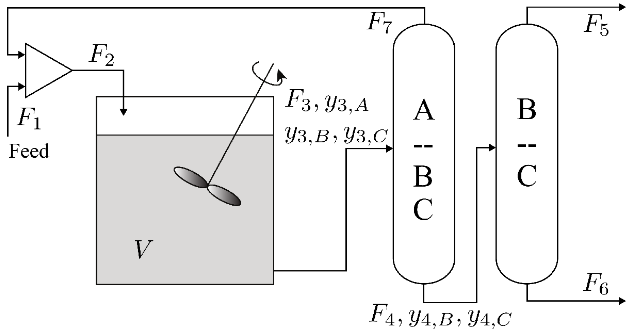
</div>
<p style='text-align: center;'>Figure 1: The process flow diagram for the CSTR-Separator-Recycle system.</p>

For simplicity, the reactions will be first-order (no dependence on $Cl_2$) with respect to benzene ($A$) and chlorobenzene ($B$). The molar volumes of each species are: $V_A = 8.937 \times 10^{-2}$ m³/kmol, $V_B = 1.018 \times 10^{-1}$ m³/kmol, and $V_C = 1.13 \times 10^{-1}$ m³/kmol with dichlorobenzene as $C$. The feed is considered to be pure $A$ (ignoring $Cl_2$). The rate constants are $k_1 = 0.40$ h⁻¹ and $k_2 = 0.055$ h⁻¹. The steady-state model equations are:

\begin{array}{rclr}
F_1 +F_7 &=& F_2 &(\text{mixer})\\	
	y_{3,A}F_3 &=& F_2 - r_1V&(\text{reactor})\\
	y_{3,B}F_3 &=&  (r_1 - r_2)V&(\text{reactor})\\
	y_{3,C}F_3 &=&  r_2V&(\text{reactor})\\
	F_3&=&F_4+F_7 &(\text{separator 1})\\
	y_{3,B}F_3&=&y_{4,B}F_4 &(\text{separator 1})\\
	y_{3,C}F_3&=&y_{4,C}F_4 &(\text{separator 1})\\
	F_4&=&F_5+F_6 &(\text{separator 2})\\
	y_{4,B}F_4 &=& F_5&(\text{separator 2})\\
	y_{3,A} + y_{3,B} + y_{3,C} &=& 1&(\text{relationship})\\
	y_{4,B} + y_{4,C} &=& 1&(\text{relationship})
\end{array}

where $y_{i,j}$ is the mole fraction of $j \in \{A,B,C\}$ in Stream $i \in \{3,4\}$ (with $y_{4,A}=0$) and $r_1$ and $r_2$ are the reaction rates [kmol (m³h)⁻¹] defined as:

\begin{array}{rcl}
r_1 &=& k_1y_{3,A}/(y_{3,A}V_A + y_{3,B}V_B + y_{3,C}V_C)\\
r_2 &=& k_2y_{3,B}/(y_{3,A}V_A + y_{3,B}V_B + y_{3,C}V_C)
\end{array}

with the variable vector $\mathbf{x} \in \mathbb{R}^{12}:$

$$ \mathbf{x} = (V, F_1, F_2,y_{3,A},y_{3,B},y_{3,C},F_3,y_{4,B},y_{4,C},F_4, F_6,F_7). $$


#### __1.1 &nbsp; Performance Specifications__
We must produce at least 25 kmol/h of $B$ ($F_5 \ge 25$) and cannot have a reactor larger than 10 m³ due to space limitations. From a laboratory study, it was found that the residence time $\tau$ for the reactor must be at least 475 seconds. Residence time [h] can be defined as:

$$ \tau = \frac{V}{F_3(y_{3,A}V_A+y_{3,B}V_B+y_{3,C}V_C)}. $$

#### __1.2 &nbsp; Design Problem__
We will consider an economic objective for our optimization problem as the total annualized costs of the unit operations. The total annualized cost of the CSTR is given by

$$ f_{CSTR} = (25764 + 8178V)/2.5, $$

and the total annualized cost of the separator train is given by:

\begin{array}{rcl}
s_1^{cap} &=& 132718+F_3(369y_{3,A}-1113.9y_{3,B})\\
s_2^{cap} &= &25000+F_4(6984.5y_{4,B}-3869.53y_{4,C}^2)\\
s_1^{op}  &= &F_3(3+36.11y_{3,A}+7.71y_{3,B})(26.32\times 10^{-3})\\
s_2^{op}  &=& F_4(26.21+29.45y_{4,B})(26.32\times 10^{-3})\\
f_{sep}  &=& (s_1^{cap}+s_2^{cap})/2.5+0.52(s_1^{op}+s_2^{op}).
\end{array}

The total annualized cost of the complete system is then given by

$$ f_{total} = f_{CSTR} + f_{sep}. $$

***
### __2. &nbsp; Modeling and Simplifying Model Using ModelingToolkit__

This system can be modeled symbolically and simplified using the `ModelingToolkit.jl` package, which can be downloaded by typing `] add ModelingToolkit` into the Julia terminal.

In [17]:
using ModelingToolkit

First, we define the state variables with `@variables` and model parameters with `@parameters`. Note that the design variables $V$ and $F_1$ are considered parameters so we have a square system (10 equations, 10 unknowns).

In [18]:
# State variables
ModelingToolkit.@variables F₂ y_3A y_3B y_3C F₃ y_4B y_4C F₄ F₆ F₇

# Model parameters and design variables
ModelingToolkit.@parameters k₁ k₂ V_A V_B V_C V F₁;

Next, we can write symbolic expressions for $r_1$, $r_2$, and $F_5$ to help simplify our model equations.

In [19]:
# Symbolic expressions for reaction rates and F₅
r₁ = (k₁*y_3A)/(y_3A*V_A + y_3B*V_B + y_3C*V_C)
r₂ = (k₂*y_3B)/(y_3A*V_A + y_3B*V_B + y_3C*V_C)
F₅ = (y_4B * F₄);

The variables, parameters, and steady-state model equations are then used to construct the `NonlinearSystem`.

In [20]:
# Steady-state model equations
eqs = [
    F₁ + F₇ ~ F₂
    (y_3A * F₃) ~ F₂ - r₁*V
    (y_3B * F₃) ~ (r₁ - r₂)*V
    (y_3C * F₃) ~ r₂*V
    F₃ ~ F₄ + F₇
    (y_3B * F₃) ~ (y_4B * F₄)
    (y_3C * F₃) ~ (y_4C * F₄)
    F₄ ~ F₅ + F₆
    y_3A + y_3B + y_3C ~ 1
    y_4B + y_4C ~ 1
]

# Variables and parameters
vars = [F₂, y_3A, y_3B, y_3C, F₃, y_4B, y_4C, F₄, F₆, F₇]
pars = [k₁, k₂, V_A, V_B, V_C, V, F₁]

# Building and simplifying model
@mtkbuild ns = NonlinearSystem(eqs, vars, pars)

# Display simplified model equations and unknowns
display(full_equations(ns))
display(unknowns(ns))

4-element Vector{Equation}:
 0 ~ -F₃*y_3B + V*((-k₂*y_3B) / (V_A*(1 - y_3B - y_3C) + V_B*y_3B + V_C*y_3C) + (k₁*(1 - y_3B - y_3C)) / (V_A*(1 - y_3B - y_3C) + V_B*y_3B + V_C*y_3C))
 0 ~ (V*k₂*y_3B) / (V_A*(1 - y_3B - y_3C) + V_B*y_3B + V_C*y_3C) - F₃*y_3C
 0 ~ -F₃*y_3B + (F₁ + F₃ + (V*k₁*(-1 + y_3B + y_3C)) / (V_A*(1 - y_3B - y_3C) + V_B*y_3B + V_C*y_3C) + F₃*(-1 + y_3B + y_3C))*(1 - y_4C)
 0 ~ -F₃*y_3C + (F₁ + F₃ + (V*k₁*(-1 + y_3B + y_3C)) / (V_A*(1 - y_3B - y_3C) + V_B*y_3B + V_C*y_3C) + F₃*(-1 + y_3B + y_3C))*y_4C

4-element Vector{SymbolicUtils.BasicSymbolic{Real}}:
 F₃
 y_3C
 y_3B
 y_4C

`@mtkbuild` simplifies the model down to 4 equations and 4 unknowns, significantly reducing the dimensionality of this system. The variables that were eliminated during the simplification process are called "observed variables," and their expressions can be obtained using `observed(::NonlinearSystem)`.

In [21]:
display(observed(ns))

6-element Vector{Equation}:
 y_3A ~ 1 - y_3B - y_3C
 y_4B ~ 1 - y_4C
 F₂ ~ (V*k₁*y_3A) / (V_A*y_3A + V_B*y_3B + V_C*y_3C) + F₃*y_3A
 F₇ ~ -F₁ + F₂
 F₄ ~ F₃ - F₇
 F₆ ~ F₄ - F₄*y_4B

***
### __3. &nbsp; ModelingToolkit to Standard Function__

Now that we've simplified our model, we need to covert the symbolic model equations into standard Julia functions in order to use them with `EAGO.jl`. This can be accomplished through the use of `Symbolics.build_function`, which generates a numerically-usable function from a symbolic expression. Since `Symbolics.jl` is already built into `ModelingToolkit.jl`, no additional packages need to be installed. 

To simplify the use of `build_function` for our purposes, we first create the function `ns_to_function()` that takes in a `NonlinearSystem`, a vector of parameters, and a vector of function inputs, and returns a vector of standard Julia functions corresponding to the simplified model equations in the nonlinear system. 


In [22]:
# Converts symbolic model equations into standard Julia functions
function ns_to_function(ns::NonlinearSystem, params::Vector{Pair{Num,Float64}}, vars::Vector{Num})
    function_holder = []
    # For each model equation, substitute parameter values and create function
    for eqn in full_equations(ns)
        expr = substitute(eqn.rhs, Dict{Num,Any}(params))
        new_func = build_function(expr, vars..., expression = Val{false})
        push!(function_holder, new_func)
    end
    return function_holder
end;

To use this function, we first assign values to our known parameters, define our function inputs, and then call `ns_to_function()` to obtain our desired functions.


In [23]:
# Assign parameter values
params = [
    k₁ => 0.40,
    k₂ => 0.055,
    V_A => 8.937e-2,
    V_B => 1.018e-1,
    V_C => 1.130e-1
]

# Function inputs (design and state variables)
x = [V, F₁, y_3B, y_3C, F₃, y_4C]

# Create functions for each model equation as a function of design and state variables
f = ns_to_function(ns, params, x);

We now have standard Julia functions for each model equation which can be used as equality constraints in our `JuMP.jl` model. 

We'll also create functions for our inequality constraints ($F_5$, $\tau$) and objective function ($f_{total}$). Since these functions are not expressed in terms of the two design variables ($V$ and $F_1$) and the four state variables ($y_{3,B}$, $y_{3,C}$, $F_3$, $y_{4,C}$), we'll create a function `expr_to_function()` to substitute the `NonlinearSystem` observed variables into our input expression before calling `build_function`.

All we have to do now is write the symbolic expressions for $F_5$, $\tau$, and $f_{total}$, then call `expr_to_function()` for each expression.

In [24]:
# Converts symbolic expression into standard Julia function, substituting parameter and observed variable expressions
function expr_to_function(expr::Num, ns::NonlinearSystem, params::Vector{Pair{Num,Float64}}, vars::Vector{Num})
    # Creates a dictionary of parameter and observed variable substitutions
    substitute_dict = Dict{Num,Any}(params)
    for eqn in observed(ns)
        substitute_dict[eqn.lhs] = eqn.rhs
    end
    # Makes substitutions until no substitutions can be made
    while ~isempty(intersect(string.(get_variables(expr)), string.(keys(substitute_dict))))
        expr = substitute(expr, substitute_dict)
    end
    return build_function(expr, vars..., expression = Val{false})
end

# Symbolic expression for F₅
exprF5 = y_4B*F₄

# Symbolic expression for τ
exprTau = V/(F₃*(y_3A*V_A + y_3B*V_B + y_3C*V_C))

# Symbolic expressions for CSTR and separator costs
f_CSTR = (25764 + 8178*V)/2.5
s1cap = 132718 + F₃*(369*y_3A - 1113.9*y_3B)
s2cap = 25000 + F₄*(6984.5*y_4B - 3869.53*y_4C^2)
s1op = F₃*(3+36.11*y_3A + 7.71*y_3B)*26.32e-3
s2op = F₄*(26.21 + 29.45*y_4B)*26.32e-3;
f_Sep = (s1cap+s2cap)/2.5 + 0.52*(s1op+s2op)

# Symbolic expression for total cost (objective function)
exprTotCost = f_CSTR + f_Sep

# Create functions for each expression as a function of design and state variables
F5 = expr_to_function(exprF5, ns, params, x)
Tau = expr_to_function(exprTau, ns, params, x)
TotCost = expr_to_function(exprTotCost, ns, params, x);

***
### __4. &nbsp; Solving Optimization Problem With EAGO__

To formulate and solve the design problem, we'll begin by creating a `JuMP.jl` model that uses the `EAGO.jl` solver. We'll also use the `GLPK.jl` subsolver because it greatly accelerates convergence for this particular system.

In [25]:
using JuMP, EAGO, GLPK

# Using GLPK subsolver for EAGO
factory = () -> EAGO.Optimizer(SubSolvers(;r=GLPK.Optimizer()))
m = Model(optimizer_with_attributes(factory,"branch_cvx_factor" => 0.75,"output_iterations" =>200));

Next, we need to define bounds for our design variables ($V$, $F_1$) and state variables ($y_{3,B}$, $y_{3,C}$, $F_3$, $y_{4,C}$). This gives us a total of 6 decision variables in our optimization problem. 

In [26]:
# Define variable bounds
xL = [ 5.0, 25.0, 0.1, 0.001,  75.0, 0.01]
xU = [10.0, 50.0, 0.5,   0.1, 125.0,  0.1]
# x = ( V,  F₁,  y_3B,  y_3C,   F₃,  y_4C)
@variable(m, xL[i] <= x[i=1:6] <= xU[i]);

It's important to note that defining "good" bounds is especially important for deterministic global solvers like `EAGO.jl` because of the set arithmetic and interval and convex analyses required to guarantee global optimality. Based on simple linear constraints and understanding what our variables physically represent, we can easily eliminate erroneous regions from the search space and drastically reduce computational cost. For example, we know the reactor volume must be less than or equal to 10 m³, but we also know it should be at least a few cubic meters large, so we bound $V$ between 5 and 10. Similarly, we know we must produce at least 25 kmol/h of $B$, but this is only possible if there are at least 25 kmol/h of $A$ entering the system since we are operating under steady-state conditions with one influent and two effluent streams.

Once proper bounds are defined, we continue by registering our user-defined functions and defining our nonlinear constraints (model equations and performance specifications) and objective (minimizing total annualized costs).

In [27]:
# Register user-defined functions
JuMP.register(m, :f1, 6, f[1], autodiff=true)
JuMP.register(m, :f2, 6, f[2], autodiff=true)
JuMP.register(m, :f3, 6, f[3], autodiff=true)
JuMP.register(m, :f4, 6, f[4], autodiff=true)
JuMP.register(m, :F5, 6, F5, autodiff=true)
JuMP.register(m, :Tau, 6, Tau, autodiff=true)
JuMP.register(m, :TotCost, 6, TotCost, autodiff=true)

# Define nonlinear constraints (model equations)
@NLconstraint(m, e1, f1(x...) == 0)
@NLconstraint(m, e2, f2(x...) == 0)
@NLconstraint(m, e3, f3(x...) == 0)
@NLconstraint(m, e4, f4(x...) == 0)

# Define nonlinear constraints (performance specifications)
@NLconstraint(m, c1, F5(x...) ≥ 25.0)
@NLconstraint(m, c2, Tau(x...) ≥ 475.0/3600.0)

# Define nonlinear objective (minimize total annualized costs)
@NLobjective(m, Min, TotCost(x...))

We're now ready to solve the optimal design problem. We'll `@time` the solver so we can compare convergence times for reduced-space vs full-space formulations later.

In [28]:
# Solve optimization problem
@time JuMP.optimize!(m)

-----------------------------------------------------------------------------------------------------------------------------
|  Iteration #  |     Nodes    | Lower Bound  |  Upper Bound  |      Gap     |     Ratio    |     Time     |    Time Left   |
-----------------------------------------------------------------------------------------------------------------------------
|          200  |           79 |    1.563E+05 |    1.699E+05 |   1.362E+04 |    8.015E-02 |    5.403E+01 |    3.546E+03 |
|          400  |          105 |    1.641E+05 |    1.699E+05 |   5.771E+03 |    3.397E-02 |    6.846E+01 |    3.532E+03 |
|          600  |          125 |    1.668E+05 |    1.699E+05 |   3.063E+03 |    1.803E-02 |    7.107E+01 |    3.529E+03 |
|          800  |          145 |    1.687E+05 |    1.699E+05 |   1.208E+03 |    7.111E-03 |    7.141E+01 |    3.529E+03 |
|         1000  |          161 |    1.691E+05 |    1.699E+05 |   7.463E+02 |    4.393E-03 |    7.149E+01 |    3.529E+03 |
|         12

We've identified a global optimal solution $\mathbf{x}^* = (8.4594, 26.3167, 0.2631, 0.01386, 95.0215, 0.05003)$. Keep in mind that we can readily calculate values for the observed variables since we have their explicit expressions written in terms of these decision variables.

***
### __5. &nbsp; Full-Space Formulation (No Model Simplification)__

To compare and showcase the full-space optimization formulation for this system, we'll quickly formulate and solve the design problem with all 10 model equations using the full variable vector

$$ \mathbf{x} = (V, F_1, F_2,y_{3,A},y_{3,B},y_{3,C},F_3,y_{4,B},y_{4,C},F_4, F_6,F_7). $$

We can generate functions for each of the original model equations by first initializing the model using `@named` instead of `@mtkbuild` to exclude the structural simplification step.

In [29]:
# Initialize model without structural simplification
@named fns = NonlinearSystem(eqs, vars, pars)

# Display full model equations
display(full_equations(fns))

10-element Vector{Equation}:
 0 ~ -F₁ + F₂ - F₇
 0 ~ F₂ + (-V*k₁*y_3A) / (V_A*y_3A + V_B*y_3B + V_C*y_3C) - F₃*y_3A
 0 ~ -F₃*y_3B + V*((k₁*y_3A) / (V_A*y_3A + V_B*y_3B + V_C*y_3C) + (-k₂*y_3B) / (V_A*y_3A + V_B*y_3B + V_C*y_3C))
 0 ~ (V*k₂*y_3B) / (V_A*y_3A + V_B*y_3B + V_C*y_3C) - F₃*y_3C
 0 ~ -F₃ + F₄ + F₇
 0 ~ -F₃*y_3B + F₄*y_4B
 0 ~ -F₃*y_3C + F₄*y_4C
 0 ~ -F₄ + F₆ + F₄*y_4B
 0 ~ 1 - y_3A - y_3B - y_3C
 0 ~ 1 - y_4B - y_4C

Then, we redefine our function inputs and generate our functions in the same way as before.

In [30]:
# Full variable vector
x = [V, F₁, F₂, y_3A, y_3B, y_3C, F₃, y_4B, y_4C, F₄, F₆, F₇]

# Create functions for each model equation as a function of the full variable vector
ff = ns_to_function(fns, params, x)

# Create functions for each expression as a function of the full variable vector
fF5 = expr_to_function(exprF5, fns, params, x)
fTau = expr_to_function(exprTau, fns, params, x)
fTotCost = expr_to_function(exprTotCost, fns, params, x);

We'll define a new `JuMP.jl` model with the same settings, define bounds for each variable, register functions, define constraints and objective, then solve the optimization problem.

In [31]:
n = Model(optimizer_with_attributes(factory,"branch_cvx_factor" => 0.75,"output_iterations" =>200))

# Define variable bounds
# New variables:     v    v                       v            v     v      v
xL = [ 5.0, 25.0,  75.0, 0.5, 0.1, 0.001,  75.0, 0.9, 0.01,  25.0,  0.0,  50.0]
xU = [10.0, 50.0, 125.0, 1.0, 0.5,   0.1, 125.0, 1.0,  0.1,  50.0, 10.0, 100.0]
# x = ( V,   F₁,    F₂, y_3A, y_3B, y_3C,  F₃,  y_4B, y_4C,   F₄,   F₆,    F₇)
@variable(n, xL[i] <= x[i=1:12] <= xU[i])

# Register user-defined functions
JuMP.register(n, :f1, 12, ff[1], autodiff=true)
JuMP.register(n, :f2, 12, ff[2], autodiff=true)
JuMP.register(n, :f3, 12, ff[3], autodiff=true)
JuMP.register(n, :f4, 12, ff[4], autodiff=true)
JuMP.register(n, :f5, 12, ff[5], autodiff=true)
JuMP.register(n, :f6, 12, ff[6], autodiff=true)
JuMP.register(n, :f7, 12, ff[7], autodiff=true)
JuMP.register(n, :f8, 12, ff[8], autodiff=true)
JuMP.register(n, :f9, 12, ff[9], autodiff=true)
JuMP.register(n, :f10, 12, ff[10], autodiff=true)
JuMP.register(n, :F5, 12, fF5, autodiff=true)
JuMP.register(n, :Tau, 12, fTau, autodiff=true)
JuMP.register(n, :TotCost, 12, fTotCost, autodiff=true)

# Define nonlinear constraints (model equations)
@NLconstraint(n, e1, f1(x...) == 0)
@NLconstraint(n, e2, f2(x...) == 0)
@NLconstraint(n, e3, f3(x...) == 0)
@NLconstraint(n, e4, f4(x...) == 0)
@NLconstraint(n, e5, f5(x...) == 0)
@NLconstraint(n, e6, f6(x...) == 0)
@NLconstraint(n, e7, f7(x...) == 0)
@NLconstraint(n, e8, f8(x...) == 0)
@NLconstraint(n, e9, f9(x...) == 0)
@NLconstraint(n, e10, f10(x...) == 0)

# Define nonlinear constraints (performance specifications)
@NLconstraint(n, c1, F5(x...) ≥ 25.0)
@NLconstraint(n, c2, Tau(x...) ≥ 475.0/3600.0)

# Define nonlinear objective (minimize total annualized costs)
@NLobjective(n, Min, TotCost(x...))

In [32]:
# Solve optimization problem
@time JuMP.optimize!(n)

-----------------------------------------------------------------------------------------------------------------------------
|  Iteration #  |     Nodes    | Lower Bound  |  Upper Bound  |      Gap     |     Ratio    |     Time     |    Time Left   |
-----------------------------------------------------------------------------------------------------------------------------
|          200  |           61 |    1.648E+05 |    1.699E+05 |   5.038E+03 |    2.966E-02 |    3.610E+01 |    3.564E+03 |
|          400  |          109 |    1.661E+05 |    1.699E+05 |   3.729E+03 |    2.195E-02 |    5.183E+01 |    3.548E+03 |
|          600  |          149 |    1.667E+05 |    1.699E+05 |   3.183E+03 |    1.874E-02 |    9.516E+01 |    3.505E+03 |
|          800  |          201 |    1.670E+05 |    1.699E+05 |   2.879E+03 |    1.695E-02 |    1.095E+02 |    3.490E+03 |
|         1000  |          217 |    1.674E+05 |    1.699E+05 |   2.462E+03 |    1.449E-02 |    1.104E+02 |    3.490E+03 |
|         12

It takes three times as many iterations and significantly more memory allocations for `EAGO.jl` to converge with the full-space formulation, demonstrating the advantages of reduced-space formulations. Because global solvers suffer from the curse of dimensionality, reducing the number of decision variables through model simplifications can improve performance and therefore broaden the scope of problems for which global solvers can be applied. This tutorial introduces user-defined functions that provide an easy way to use ModelingToolkit's intuitive modeling interface and model simplification features to create reduced-space formulations in a way that is compatible with the `EAGO.jl` solver.